In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import random
%pylab inline
import scipy.stats as stats
import pomegranate as pg
from pomegranate import *
import scipy.stats as st
import illustris_python as il
from calculate_galaxy_circularity import *
from pandas import *
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import quad
from matplotlib.colors import LogNorm
from scipy.stats.stats import pearsonr,spearmanr,kendalltau

Populating the interactive namespace from numpy and matplotlib


/verafs/scratch/phy200017p/yjagvara/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text major ticklabel objects>)

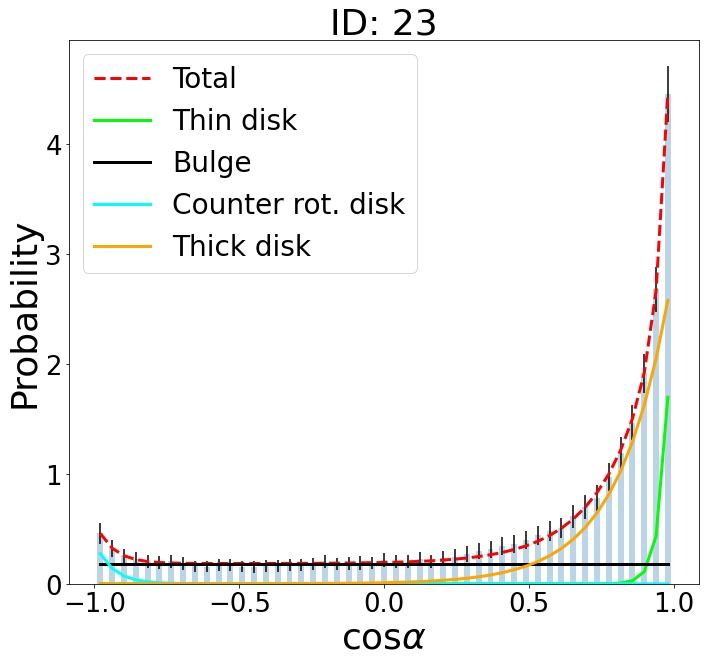

In [81]:
basePath= '/verafs/scratch/phy200017p/share/TNG100-1/output'
snapNum=99

gal_id = 23 
num_r_half = 5 
litte_h = 0.6774

fields = ['SubhaloGrNr', 'SubhaloMassInRadType', 'SubhaloPos', 'SubhaloHalfmassRadType','SubhaloHalfmassRad','SubhaloHalfmassRadType']
galaxy_table = loadSubhalos(basePath, snapNum, fields=fields)

r_1_2_star = galaxy_table['SubhaloHalfmassRadType'][gal_id][4] 
Lbox=np.array([75.0]*3)
gal_position = galaxy_center(gal_id, galaxy_table)
m_dm=0.000505574296436975

# load stellar particle positions and masses
ptcl_coords = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Coordinates'])/1000.0
ptcl_vels = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Velocities'])
ptcl_masses = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Masses'])*10.0**10 
#ptcl_metal = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['GFM_Metallicity'])

# load dm particle positions and masses
#dm_ptcl_coords = loadSubhalo(basePath, snapNum, gal_id, 1, fields=['Coordinates'])/1000.0
#dm_ptcl_vels = loadSubhalo(basePath, snapNum, gal_id, 1, fields=['Velocities'])
#dm_ptcl_masses = loadSubhalo(basePath, snapNum, gal_id, 1, fields=['Masses'])*10.0**10
 
 
# load all particles positions and masses
all_ptcl_coords = loadSubhaloAll(basePath, snapNum, gal_id, field='Coordinates')/1000.0 
all_ptcl_masses = loadSubhaloAll(basePath, snapNum, gal_id, field='Masses', m_dm=m_dm)*10.0**10

# center and account for PBCs
ptcl_coords = format_particles(gal_position, ptcl_coords, Lbox)
all_ptcl_coords = format_particles(gal_position, all_ptcl_coords, Lbox)
  
#dm_ptcl_coords = format_particles(gal_position, dm_ptcl_coords, Lbox)
# use center of mass velocity to subtract bulk velocity
ptcl_vels = format_velocities(ptcl_vels, ptcl_masses, basePath, snapNum)

# use a subset of particles for stellar properties
ptcl_mask = particle_selection(gal_id, ptcl_coords, galaxy_table, basePath, snapNum, radial_mask=True, num_r_half=num_r_half)

# specific angular momentum of the stellar system (use selected disk stars)
L = specific_angular_momentum(ptcl_coords[ptcl_mask], ptcl_vels[ptcl_mask], ptcl_masses[ptcl_mask])

# radial position of stellar particles
r = np.sqrt(np.sum(ptcl_coords*ptcl_coords, axis=-1))

#r_dm = np.sqrt(np.sum(dm_ptcl_coords*dm_ptcl_coords, axis=-1))

# circular velocity at the radial position of stellar particles
v_circs, v_circs_raw = circular_velocity(r, all_ptcl_coords, all_ptcl_masses)

# circularity parameter for stellar particles
epsilons, j_s_over_j_circ = circularity(ptcl_coords[ptcl_mask], ptcl_vels[ptcl_mask], ptcl_masses[ptcl_mask], v_circs[ptcl_mask], L)

# fraction of stellar mass with circularity > a threshold (use selected disk stars)
f_disk = disk_fraction(ptcl_masses[ptcl_mask], epsilons, disk_threshold=0.7)

#cosine of the angle between the orbital angular momentum of the particle and that of the galaxy system
cos_alpha = particle_cos_alpha(ptcl_coords[ptcl_mask], ptcl_vels[ptcl_mask], L)

#cosine of the angle between the radial vector and the spin axis of the galaxy
cos_beta = particle_cos_beta(ptcl_coords[ptcl_mask], L)
cos_alpha = particle_cos_alpha(ptcl_coords[ptcl_mask], ptcl_vels[ptcl_mask], L)
sample_size = 50000#particle_number_cut
masses = ptcl_masses[ptcl_mask] 
coords = ptcl_coords[ptcl_mask]

if len(ptcl_masses[ptcl_mask]) > sample_size:
    indexes = np.arange(len(ptcl_masses[ptcl_mask]))
    random_index = np.random.choice( indexes, size=sample_size, replace = False, p = ptcl_masses[ptcl_mask]/sum(ptcl_masses[ptcl_mask]) )
    masses =  masses[random_index]
    epsilons = epsilons[random_index]
    cos_alpha = cos_alpha[random_index]
    j_s_over_j_circ= j_s_over_j_circ[random_index]
    r=r[random_index]
    #L=L[random_index]
    coords = coords[random_index]

# # escape velocity at the radial position of stellar particles
# v_esc,ptcl_r, m_within_r  = escape_velocity(r, all_ptcl_coords, all_ptcl_masses)

# m_within_r_all, r_ptcl_all = mass_within(r,  all_ptcl_coords, all_ptcl_masses)
# m_within_r_star, r_ptcl_star = mass_within(r, ptcl_coords, ptcl_masses)
# #m_within_r_dm, r_ptcl_dm = mass_within(r,  dm_ptcl_coords, dm_ptcl_masses)

def func(x, A, B, C, D, F, G, H):
        return  A*np.exp(B * x) + C + D*np.exp(F*x) + G*np.exp(H*x)
f_disk = disk_fraction(masses, epsilons, disk_threshold=0.7)
nan_mask = ~np.isnan(j_s_over_j_circ)
j_s_over_j_circ = j_s_over_j_circ[nan_mask]
cos_alpha = cos_alpha[nan_mask]
masses = masses[nan_mask]

bin_num = 50
bins = np.linspace(-1,1,bin_num)
hist, bins = np.histogram(cos_alpha, bins=bins,density=True )



boot_N = 1000
rands = np.random.choice(cos_alpha,   size=(boot_N, len(cos_alpha)),    replace = True)
hist_list = []
for i in range(boot_N):
    hist1, bins1 = np.histogram(rands[i], bins=bins,density=True)
    hist_list.append(hist1)

cos_means = np.mean(hist_list, axis=0)
cos_err = np.std(hist_list, axis=0)
#cos_err = sqrt(hist)
sigma=cos_err
sigma[sigma == 0] = 1
popt, pcov = curve_fit(func, center, hist,sigma=sigma, bounds= ( (0, 1 , 0,0,-np.inf,0, 1) , (0.1, np.inf,np.inf,0.01,-1, 0.01, np.inf) ) , maxfev = 90000)
r = hist - func(center, *popt)

chisq = sum((r / sigma) ** 2)

int_disk_1,         err_d   =  quad( lambda x: popt[0] * np.exp(popt[1]*x) , -1,1  )
int_disk_2,         err_d   =  quad( lambda x: popt[5] * np.exp(popt[6]*x) , -1,1  )
int_disk_counter, err_d_c =  quad( lambda x: popt[3] * np.exp(popt[4]*x) , -1,1  )
int_bulge,        err_b   =  quad( lambda x: popt[2] , -1,1  )
int_disk = int_disk_1+int_disk_2
width = 0.5 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(52, 10))
plt.subplot(1,4,1 )
plt.bar(center, cos_means, align='center',width=width, yerr=6*cos_err,alpha=0.3)
ylabel('Probability', fontsize = 36)
xlabel(r'cos$\alpha$' , fontsize = 36)
title('ID: '+str(gal_id), fontsize = 36)
def func(x, A, B, C, D, F, G, H):
    return  A*np.exp(B * x) + C + D*np.exp(F*x) + G*np.exp(H*x)
sigma = (cos_err)
sigma[sigma == 0] = 1
#print(sigma)

popt, pcov = curve_fit(func, center, hist,sigma=sigma, bounds= ( (0, 1 , 0,0,-np.inf,0, 1) , (0.01, np.inf,np.inf,0.01,-1, 0.01, np.inf) ) , maxfev = 90000)
plt.plot(center, func(center, *popt), '--',color='red', label="Total", lw=3)
plt.plot(center, func(center, popt[0], popt[1], 0,0,0,0,0),  'lime',label="Thin disk", lw=3)
plt.plot(center, func(center, 0, 0, popt[2],0,0, 0,0), 'black',label='Bulge', lw=3)
plt.plot(center, func(center,0,0,0, popt[3], popt[4],0,0 ), 'cyan', label='Counter rot. disk', lw=3)
plt.plot(center, func(center,0,0,0, 0,0, popt[5], popt[6]), 'orange',label='Thick disk',lw=3)
plt.legend( prop={'size': 28})
plt.xticks([-1,-0.5,0,0.5,1], fontsize = 26)
plt.yticks( fontsize = 26)
 

f_bulge 0.3893115704891943


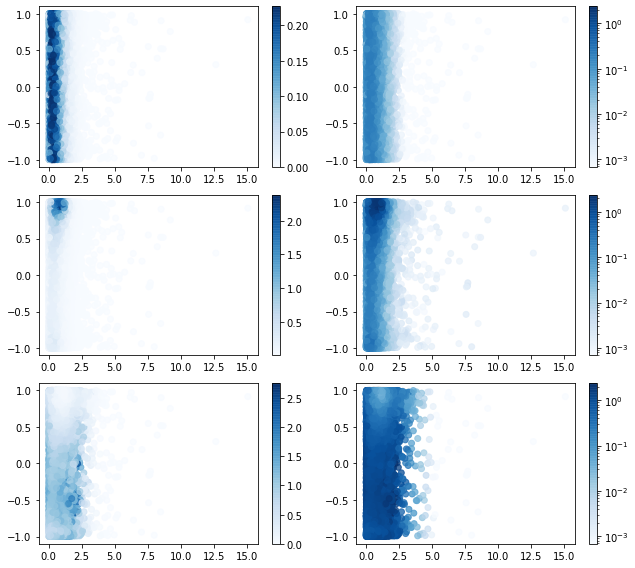

In [82]:
full_mass = masses
cos_mask = cos_alpha<0.5
#Get the bulge model
# j_s_over_j_circ = j_s_over_j_circ[nan_mask]
# cos_alpha = cos_alpha[nan_mask]
# full_mass = full_mass[nan_mask]
# cos_mask=cos_mask[nan_mask]
bulge_mass= masses[cos_mask]

b = GammaDistribution.from_samples(j_s_over_j_circ[cos_mask])
b.fit (j_s_over_j_circ[cos_mask], weights=bulge_mass)
f_bulge = 1 - int_disk
print('f_bulge', f_bulge)


#Numerator of probability from fit
w_i_numerator = b.probability(j_s_over_j_circ)*f_bulge*0.5

## Peform the kernel density estimate on all data points and plot it
cos_js = np.vstack([j_s_over_j_circ, cos_alpha])
cos_js_disk = np.vstack([j_s_over_j_circ[~cos_mask], cos_alpha[~cos_mask]])
kernel = stats.gaussian_kde(cos_js , bw_method = 0.1,  weights = full_mass )
w_i_denominator = kernel( cos_js )  
w_i = w_i_numerator/w_i_denominator
# w_i_kde = w_i_numerator_kde/w_i_denominator
w_i_disk = kernel(cos_js)*int_disk/w_i_denominator
tot_for_star = w_i_disk +w_i

col=2
row=5
figure(figsize=(9,13))
subplot(row,col,1)
e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_numerator,cmap = 'Blues', alpha=0.75)
colorbar(e)
subplot(row,col,2)
e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_numerator,cmap = 'Blues', alpha=0.75,norm=LogNorm(vmin=w_i_denominator.min(), vmax=w_i_denominator.max()))
colorbar(e)
subplot(row,col,3)
e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_denominator,cmap = 'Blues', alpha=0.75)
colorbar(e)
subplot(row,col,4)
e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_denominator,cmap = 'Blues', alpha=0.75,norm=LogNorm(vmin=w_i_denominator.min(), vmax=w_i_denominator.max()))
colorbar(e)
subplot(row,col,5)
e=scatter(j_s_over_j_circ, cos_alpha, c=w_i,cmap = 'Blues', alpha=0.75)
colorbar(e)
subplot(row,col,6)
e=scatter(j_s_over_j_circ, cos_alpha, c=w_i,cmap = 'Blues', alpha=0.75,norm=LogNorm(vmin=w_i_denominator.min(), vmax=w_i_denominator.max()))
colorbar(e)

# subplot(row,col,7)
# e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_numerator_kde,cmap = 'Blues', alpha=0.75)
# colorbar(e)
# subplot(row,col,8)
# e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_numerator_kde,cmap = 'Blues', alpha=0.75,norm=LogNorm(vmin=w_i_denominator.min(), vmax=w_i_denominator.max()))
# colorbar(e)
# subplot(row,col,9)
# e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_kde,cmap = 'Blues', alpha=0.75)
# colorbar(e)
# subplot(row,col,10)
# e=scatter(j_s_over_j_circ, cos_alpha, c=w_i_kde,cmap = 'Blues', alpha=0.75,norm=LogNorm(vmin=w_i_denominator.min(), vmax=w_i_denominator.max()))
# colorbar(e)


tight_layout()



[0.95954803 0.1746012  0.06607936 ... 0.34548409 1.15374675 0.62068304]
0.13935666587016451 of the data lie outside 1


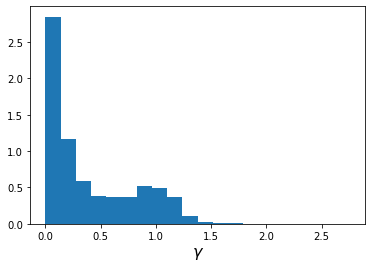

In [83]:
print(w_i)
a=plt.hist(w_i,bins=20,density=True)
print(sum(w_i[w_i>1])/len( w_i ), 'of the data lie outside 1')
xlabel(r'$\gamma$', fontsize = 16)
  

# Compare w_i with random numbers
#Generate random number uniformly

rands = np.random.uniform(low=0.0, high=1, size=(len(j_s_over_j_circ)))
bulge_mask = np.greater((w_i),(rands))

<ipython-input-84-0a7a09d69332>:20: RuntimeWarning: divide by zero encountered in true_divide
  plot(t, 0.7/t,color='red')
<ipython-input-84-0a7a09d69332>:38: RuntimeWarning: divide by zero encountered in true_divide
  plot(t, 0.7/t,color='red')
<ipython-input-84-0a7a09d69332>:50: RuntimeWarning: divide by zero encountered in true_divide
  plot(t, 0.7/t,color='red')


19399
19399


0.6140813

<Figure size 432x288 with 0 Axes>

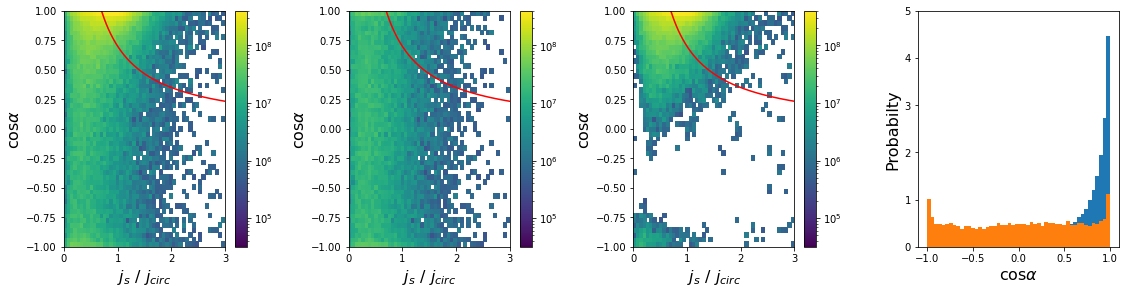

In [84]:
tight_layout(pad=3.0)
figure(figsize=(16,8))
bin_size = 50
bins_js = np.linspace(0,3,bin_size)
bins_cos = np.linspace(-1,1,bin_size)

H, xedges, yedges = np.histogram2d(j_s_over_j_circ  , cos_alpha  , bins=(bins_js, bins_cos),weights=full_mass )
subplot(2,4,1)

#H_reduce = (H/len(cos_alpha)).T
#print(DataFrame(H_reduce))
H_reduce = (H/(1)).T
#disky galaxy  f_disk=0.06891377     mass=15.429877 id= 197108 
minval = np.min(H_reduce[np.nonzero(H_reduce)])*0.1
maxval = np.max(H_reduce[np.nonzero(H_reduce)])
pc=plt.pcolormesh(xedges,yedges,H_reduce,cmap='viridis', vmin=minval, vmax=maxval, norm=matplotlib.colors.LogNorm())
plt.colorbar(pc)
xlim(0,3)
t = np.arange(0, 4, 0.01)
plot(t, 0.7/t,color='red')
ylim(-1,1)
ylabel(r'cos$\alpha$', fontsize = 16)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize = 16)


H, xedges, yedges = np.histogram2d(j_s_over_j_circ[bulge_mask] , cos_alpha[bulge_mask] , bins=(bins_js, bins_cos),weights=full_mass[bulge_mask])
subplot(2,4,2)
#H_reduce = (H/len(cos_alpha)).T
#print(DataFrame(H_reduce))
H_reduce = (H/(1)).T
#disky galaxy  f_disk=0.06891377     mass=15.429877 id= 197108 
# minval = np.min(H_reduce[np.nonzero(H_reduce)])*0.1
# maxval = np.max(H_reduce[np.nonzero(H_reduce)])
pc=plt.pcolormesh(xedges,yedges,H_reduce,cmap='viridis', vmin=minval, vmax=maxval, norm=matplotlib.colors.LogNorm())
plt.colorbar(pc)
xlim(0,3)
t = np.arange(0, 4, 0.01)
plot(t, 0.7/t,color='red')
ylim(-1,1)
ylabel(r'cos$\alpha$', fontsize = 16)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize = 16)

H, xedges, yedges = np.histogram2d(j_s_over_j_circ[~bulge_mask] , cos_alpha[~bulge_mask] , bins=(bins_js, bins_cos),weights=full_mass[~bulge_mask])
subplot(2,4,3)
H_reduce = (H/1).T
pc=plt.pcolormesh(xedges,yedges,H_reduce, cmap='viridis',vmin=minval, vmax=maxval,norm=matplotlib.colors.LogNorm())
plt.colorbar(pc)
xlim(0,3)
t = np.arange(0, 4, 0.01)
plot(t, 0.7/t,color='red')
ylim(-1,1)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize = 16)
ylabel(r'cos$\alpha$', fontsize = 16)


subplot(2,4,4)
#axvline(cos_cut, lw=2,color='y')
plt.hist(cos_alpha,bins = 50, density = True)
plt.hist(cos_alpha[bulge_mask],bins=50, density = True)
ylim(0,5)
xlabel(r'cos$\alpha$' , fontsize = 16)
ylabel(r'Probabilty' , fontsize = 16)

print(sum(bulge_mask))
print(len(j_s_over_j_circ[bulge_mask]))
tight_layout(pad=2.0) 
sum(full_mass[~bulge_mask])/sum(full_mass)


<ipython-input-85-3335a2b66ea5>:11: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(t, 0.7/t,color='black', lw=3, label="$\epsilon=0.7$")


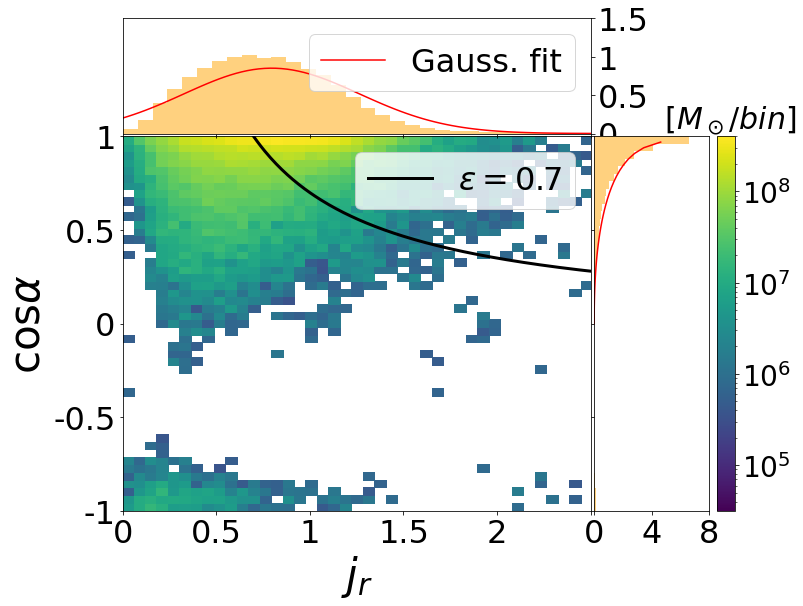

In [85]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, mass_weights):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    H, xedges, yedges = np.histogram2d(x, y , bins=(bins_js, bins_cos),weights=mass_weights)
    H_reduce = (H/1).T
    # the scatter plot:
    pc=ax.pcolormesh(xedges,yedges,H_reduce, cmap='viridis',vmin=minval, vmax=maxval,norm=matplotlib.colors.LogNorm())
    ax.set_xlim(0,2.5)
    t = np.arange(0, 4, 0.01)
    ax.plot(t, 0.7/t,color='black', lw=3, label="$\epsilon=0.7$")
    ax.legend(fontsize=32)
    ax.set_ylim(-1,1)
    ax.set_ylabel(r'cos$\alpha$', fontsize = 42)
    ax.set_xlabel(r'$j_{r}$', fontsize = 42)
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_yticklabels([-1,-0.5,0,0.5,1], fontsize = 32)
    ax.set_xticklabels([0,0.5,1,1.5,2], fontsize = 32)
    cb=colorbar(pc)
    cb.ax.tick_params(labelsize=28)  
    cb.ax.set_title(label=' [$M_\odot/bin$]', size=30)
    
    rands=linspace(0,3,100)
    bin_num = 50
    bins = np.linspace(0,3,bin_num)
    hist1, bins = np.histogram(x, bins=bins,density=True )

    width = 0.5 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    #ax_histx.bar(center, hist1, align='center',width=width, color='orange',alpha=0.5 )

    ax_histx.hist(x, bins=190,color='orange',alpha=0.5,density=True,weights=mass_weights)
    param_gauss = stats.norm.fit(x)
    pdf_fitted = stats.norm.pdf(rands, *param_gauss)
    ax_histx.plot(rands, pdf_fitted, color='r',label='Gauss. fit')
    ax_histx.legend(fontsize=32)
    
    
    param_beta = stats.beta.fit(abs(y), floc=0,fscale=1 )
    pdf_fitted = stats.beta.pdf(rands, *param_beta)
    ax_histy.hist(y, bins=50, color='orange',alpha=0.5,orientation='horizontal',density=True,weights=mass_weights)
    ax_histy.plot( pdf_fitted, rands,color='r',label='Beta fit')
    ax_histx.set_yticks([0,0.5,1,1.5])
    ax_histx.set_yticklabels([0,0.5,1,1.5], fontsize = 32)
    ax_histx.yaxis.tick_right()
    
    ax_histy.set_xticks([0,4,8])
    ax_histy.set_xticklabels([0,4,8], fontsize = 32)
    #ax_histy.yaxis.tick_right()
 
 
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figureplt.subplot(2,4,1)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(j_s_over_j_circ[~bulge_mask] , cos_alpha[~bulge_mask], ax, ax_histx, ax_histy, full_mass[~bulge_mask])
#plt.savefig('mc_disk_only.png', dpi=100,bbox_inches='tight')


<ipython-input-86-98da014385aa>:11: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(t, 0.7/t,color='black', lw=3, label="$\epsilon=0.7$")


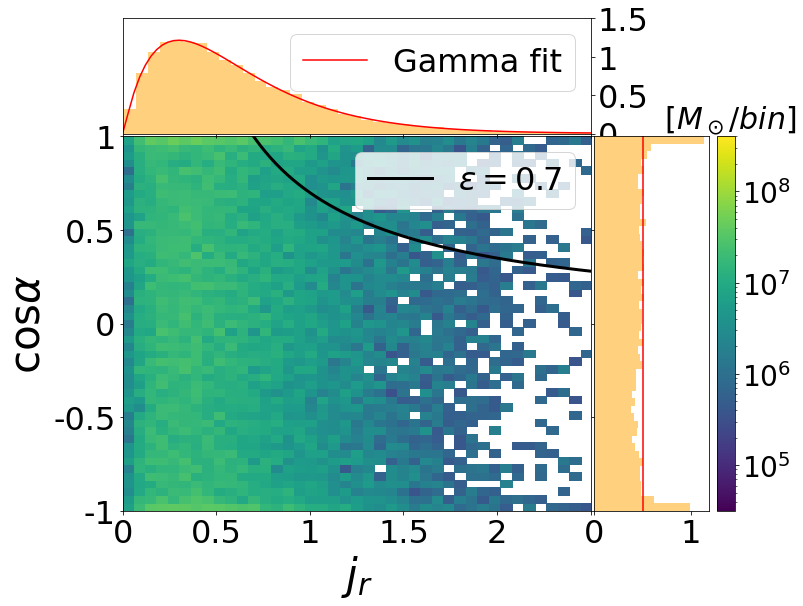

In [86]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, mass_weights):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    H, xedges, yedges = np.histogram2d(x, y , bins=(bins_js, bins_cos),weights=mass_weights)
    H_reduce = (H/1).T
    # the scatter plot:
    pc=ax.pcolormesh(xedges,yedges,H_reduce, cmap='viridis',vmin=minval, vmax=maxval,norm=matplotlib.colors.LogNorm())
    ax.set_xlim(0,2.5)
    t = np.arange(0, 4, 0.01)
    ax.plot(t, 0.7/t,color='black', lw=3, label="$\epsilon=0.7$")
    ax.legend(fontsize=32)
    ax.set_ylim(-1,1)
    ax.set_ylabel(r'cos$\alpha$', fontsize = 42)
    ax.set_xlabel(r'$j_{r}$ ', fontsize = 42)
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_yticklabels([-1,-0.5,0,0.5,1], fontsize = 32)
    ax.set_xticklabels([0,0.5,1,1.5,2], fontsize = 32)
    cb=colorbar(pc)
    cb.ax.tick_params(labelsize=28)  
    cb.ax.set_title(label=' [$M_\odot/bin$]', size=30)
    
    rands=linspace(0,3,100)
    ax_histx.hist(x, bins=60,density=True,color='orange',alpha=0.5,weights=mass_weights)
    param_gauss = stats.gamma.fit(x)
    pdf_fitted = stats.gamma.pdf(rands, *param_gauss)
    ax_histx.plot(rands, pdf_fitted, color='r',label='Gamma fit')
    ax_histx.legend(fontsize=32)
    
    
    param_beta = stats.beta.fit(abs(y), floc=0,fscale=1 )
    pdf_fitted = stats.beta.pdf(rands, *param_beta)
    ax_histy.hist(y, bins=50, orientation='horizontal',color='orange',alpha=0.5,density=True,weights=mass_weights)
    ax_histy.axvline( 1/2,color='r',label='Beta fit')
    ax_histx.set_yticks([0,0.5,1,1.5])
    ax_histx.set_yticklabels([0,0.5,1,1.5], fontsize = 32)
    ax_histx.yaxis.tick_right()
    
    ax_histy.set_xticks([0,1])
    ax_histy.set_xticklabels([0,1], fontsize = 32)
    #ax_histy.yaxis.tick_right()
 
 
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figureplt.subplot(2,4,1)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(j_s_over_j_circ[bulge_mask], cos_alpha[bulge_mask], ax, ax_histx, ax_histy, full_mass[bulge_mask])


<ipython-input-87-684415fb55f2>:11: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(t, 0.7/t,color='black', lw=3, label="$\epsilon=0.7$")


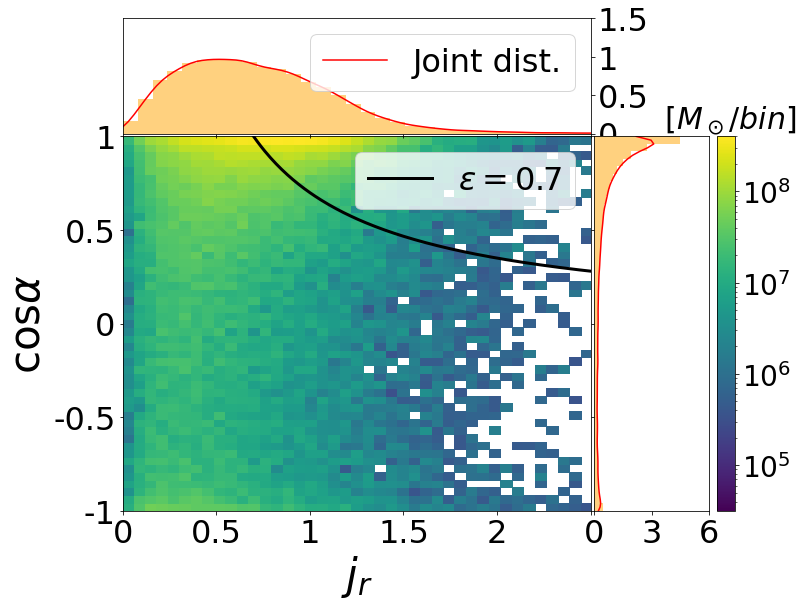

In [87]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, mass_weights):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    H, xedges, yedges = np.histogram2d(x, y , bins=(bins_js, bins_cos),weights=mass_weights)
    H_reduce = (H/1).T
    # the scatter plot:
    pc=ax.pcolormesh(xedges,yedges,H_reduce, cmap='viridis',vmin=minval, vmax=maxval,norm=matplotlib.colors.LogNorm())
    ax.set_xlim(0,2.5)
    t = np.arange(0, 4, 0.01)
    ax.plot(t, 0.7/t,color='black', lw=3, label="$\epsilon=0.7$")
    ax.legend(fontsize=32)
    ax.set_ylim(-1,1)
    ax.set_ylabel(r'cos$\alpha$', fontsize = 42)
    ax.set_xlabel(r'$j_{r}$', fontsize = 42)
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_yticklabels([-1,-0.5,0,0.5,1], fontsize = 32)
    ax.set_xticklabels([0,0.5,1,1.5,2], fontsize = 32)
    cb=colorbar(pc)
    cb.ax.tick_params(labelsize=28)  
    cb.ax.set_title(label=' [$M_\odot/bin$]', size=30)
    
    rands=linspace(0,3,100)
    ax_histx.hist(x, bins=190,density=True,color='orange',alpha=0.5,weights=mass_weights)
#     param_gauss = stats.gamma.fit(x)
#     pdf_fitted = stats.gamma.pdf(rands, *param_gauss)
    pdf_fitted = stats.gaussian_kde(x, weights=full_mass)
    #plot(rands, est(rands))
    ax_histx.plot(rands, pdf_fitted(rands), color='r',label='Joint dist.')
    ax_histx.legend(fontsize=32)
    
    rands=linspace(-1,1,100)
    pdf_fitted = stats.gaussian_kde(y, bw_method=0.05,  weights=full_mass)
    ax_histy.hist(y, bins=50, orientation='horizontal',color='orange',alpha=0.5,density=True,weights=mass_weights)
    ax_histy.plot( pdf_fitted(rands),rands, color='r',label='Joint dist.')
    ax_histx.set_yticks([0,0.5,1,1.5])
    ax_histx.set_yticklabels([0,0.5,1,1.5], fontsize = 32)
    ax_histx.yaxis.tick_right()
    
    ax_histy.set_xticks([0,3,6])
    ax_histy.set_xticklabels([0,3,6], fontsize = 32)
    #ax_histy.yaxis.tick_right()
 
 
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figureplt.subplot(2,4,1)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(j_s_over_j_circ  , cos_alpha , ax, ax_histx, ax_histy, full_mass)
plt.savefig('mc_both.png', dpi=100,bbox_inches='tight')


Bulge scale length(kpc): 1.56 ± 0.11
Bulge index:             2.92 ± 0.23
Disk scale length(kpc): 2.18 ± 0.07


Text(0.5, 0, 'Log surface density')

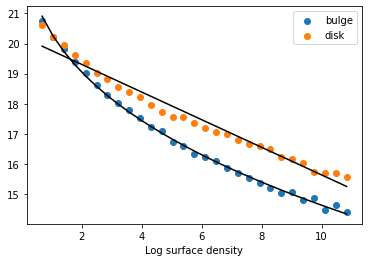

In [104]:
def scale_length_disk(x, A, B):
    return  A - (x/B)#**(1/C)

def scale_length_bulge(x, A, B,C):
    return  A - (2*C - 0.324)*( ( x/B)**(1/C)-1)
rot_matrix = rotation_matrices_from_vectors( [0,0,1],L )
new_coords = coords#np.einsum('ij,ijk->ik', coords, rot_matrix) 

r = np.sqrt(new_coords[:,0]**2 + new_coords[:,1]**2)*10**3/litte_h
r = r[nan_mask]

r_bins = np.linspace(0.5, 5*r_1_2_star, 30 )
rbins_midpoints = (r_bins[:-1] + r_bins[1:])/2.
mass_cont = stats.binned_statistic(r[bulge_mask], masses[bulge_mask], statistic='sum', bins=r_bins) # sum the partcile massses inside each bin
area = np.pi*(mass_cont[1])**2 #area of each circle
diff_area=np.diff(area) # area of the radial bin
y=np.log(mass_cont[0]/diff_area) # value of the surface density
y[y==-np.inf] = 0
err=0.1*y
err[y==0] = np.inf
scatter(rbins_midpoints, y, label = 'bulge') 
 
bulge_length_popt, bulge_length_pcov = curve_fit(scale_length_bulge, rbins_midpoints , y , sigma=err, bounds=((0,0,0),(np.inf,np.inf,100)) ,maxfev = 9000000)

plt.plot(rbins_midpoints , (scale_length_bulge(rbins_midpoints , *bulge_length_popt)), 'black')

bulge_scale_len = bulge_length_popt[1]
bulge_scale_len_err = np.sqrt(np.diag(bulge_length_pcov))[1]
bulge_index = bulge_length_popt[2]
bulge_index_err = np.sqrt(np.diag(bulge_length_pcov))[2]

#Disk
r_bins_disk = np.linspace(0.25*r_1_2_star, 5*r_1_2_star, 30 )
rbins_midpoints_disk = (r_bins_disk[:-1] + r_bins_disk[1:])/2.
mass_cont_disk = stats.binned_statistic(r[~bulge_mask], masses[~bulge_mask], statistic='sum', bins=r_bins_disk) # sum the partcile massses inside each bin
area_disk = np.pi*(mass_cont_disk[1])**2 #area of each circle

diff_area_disk=np.diff(area_disk) # area of the radial bin
y_disk=np.log(mass_cont_disk[0]/diff_area_disk) # value of the surface density

y_disk[y_disk==-np.inf] = 0

#print(sigma)
err=0.1*y_disk
err[y_disk==0] = np.inf
popt_disk, pcov_disk= curve_fit(scale_length_disk, rbins_midpoints_disk , y_disk,sigma=err, maxfev = 9000)

disk_scale_len = popt_disk[1]
disk_scale_len_err = np.sqrt(np.diag(pcov_disk))[1]
#

plt.scatter(rbins_midpoints, y_disk, label='disk') 
plt.plot(rbins_midpoints , (scale_length_disk(rbins_midpoints , *popt_disk)), 'black')

print("Bulge scale length(kpc):" , round(bulge_scale_len, 2),'±',round(bulge_scale_len_err, 2))
print("Bulge index:            " , round(bulge_index,2),  '±',round(bulge_index_err,2))
print("Disk scale length(kpc):" , round(disk_scale_len, 2),'±',round(disk_scale_len_err, 2))
legend()
xlabel('r (kpc)')
xlabel('Log surface density')

# **Beyond this point we will explore the correlation structure of the two parameters and construct a Copula**

(0.7965021885536037, 0.4688633921087444) scipy norm
KstestResult(statistic=0.0705792137330905, pvalue=5.368077062704002e-133)
(3.2222076545475833, 0.6771769059368709, 0, 1) scipy beta
KstestResult(statistic=0.05243751032748395, pvalue=1.4310846901538644e-73)

 pearson r 0.05586067218827234

 SpearmanrResult(correlation=0.16527654485274437, pvalue=2.583435258129752e-186)

 KendalltauResult(correlation=0.11157410166227641, pvalue=2.1555765505390684e-188)


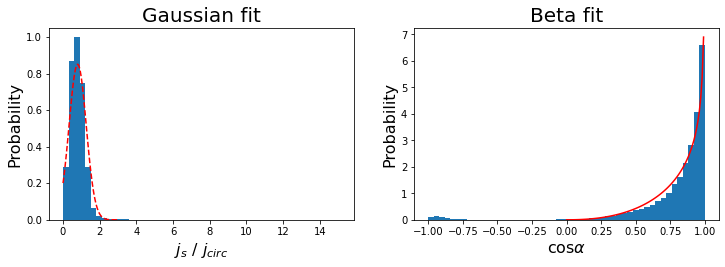

In [92]:
x=linspace(0,3,100)
figure(figsize=(12,12))
title("Disk stars")
subplot(3,2,1)
disk_j = j_s_over_j_circ[~bulge_mask]

q=plt.hist(disk_j ,bins=50, density=True) 

xlabel(r'$j_{s}$ / $j_{circ}$', fontsize = 16)
param_gauss = stats.norm.fit(disk_j)
print(param_gauss, 'scipy norm')
pdf_fitted = stats.norm.pdf(x, *param_gauss)
plt.plot(x, pdf_fitted, color='r',linestyle='dashed')
chi1 = stats.kstest(disk_j, 'norm', args=(param_gauss))
print(chi1)
title('Gaussian fit',fontsize = 20)
ylabel(r'Probability', fontsize = 16)

subplot(3,2,2)
x=linspace(0,1,100)
disk_cos = cos_alpha[~bulge_mask]
q=plt.hist( disk_cos, bins=50, density=True )


param_beta = stats.beta.fit(abs(disk_cos), floc=0,fscale=1 )
print(param_beta, 'scipy beta')
pdf_fitted = stats.beta.pdf(x, *param_beta)
plt.plot(x, pdf_fitted, color='r')
chi1 = stats.kstest(abs(disk_cos), 'beta', args=(param_beta))
print(chi1)
xlabel(r'cos$\alpha$', fontsize = 16)
ylabel(r'Probability', fontsize = 16)
title('Beta fit',fontsize = 20)


from scipy.stats.stats import pearsonr,spearmanr,kendalltau
 
print ('\n', 'pearson r', pearsonr(disk_cos, disk_j)[0])
print ('\n',spearmanr(disk_cos, disk_j))
print ('\n',kendalltau(disk_cos, disk_j))
#5.622269020193032, 0.6837327174125405, 0, 0.9999938267747492

(5.055014096847272, 0.8979098138126795, 0.21259250368042865) scipy norm
KstestResult(statistic=0.020025036696404208, pvalue=8.364748110798743e-12)
(2.190684887415704, 0.3778278842636246, 0, 1) scipy beta
KstestResult(statistic=0.14144168755780423, pvalue=0.0)

 pearson r (0.18295121535470005, 1.0875808199862642e-243)

 SpearmanrResult(correlation=0.2758717243014567, pvalue=0.0)

 KendalltauResult(correlation=0.18672371475687705, pvalue=0.0)


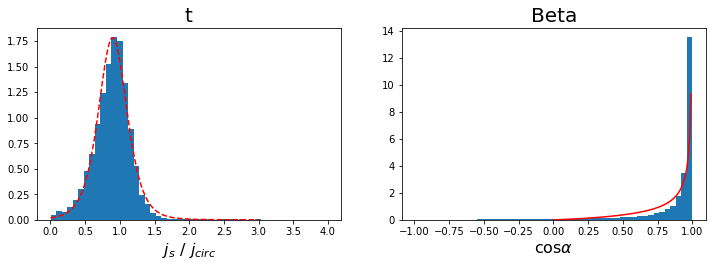

In [44]:
x=linspace(0,3,100)
figure(figsize=(12,12))
title("Disk stars")
subplot(3,2,1)
disk_j = j_s_over_j_circ[~bulge_mask]

q=plt.hist(disk_j ,bins=50, density=True) 

xlabel(r'$j_{s}$ / $j_{circ}$', fontsize = 16)
param_gauss = stats.t.fit(disk_j)
print(param_gauss, 'scipy norm')
pdf_fitted = stats.t.pdf(x, *param_gauss)
plt.plot(x, pdf_fitted, color='r',linestyle='dashed')
chi1 = stats.kstest(disk_j, 't', args=(param_gauss))
print(chi1)
title('t',fontsize = 20)

subplot(3,2,2)
x=linspace(0,1,100)
disk_cos = cos_alpha[~bulge_mask]
q=plt.hist( disk_cos, bins=50, density=True )


param_beta = stats.beta.fit(abs(disk_cos), floc=0,fscale=1 )
print(param_beta, 'scipy beta')
pdf_fitted = stats.beta.pdf(x, *param_beta)
plt.plot(x, pdf_fitted, color='r')
chi1 = stats.kstest(abs(disk_cos), 'beta', args=(param_beta))
print(chi1)
xlabel(r'cos$\alpha$', fontsize = 16)
title('Beta',fontsize = 20)


from scipy.stats.stats import pearsonr,spearmanr,kendalltau
 
print ('\n', 'pearson r', pearsonr(disk_cos, disk_j))
print ('\n',spearmanr(disk_cos, disk_j))
print ('\n',kendalltau(disk_cos, disk_j))

(3.2222076545475833, 0.6771769059368709, 0, 1)
(0.7965021885536037, 0.4688633921087444)


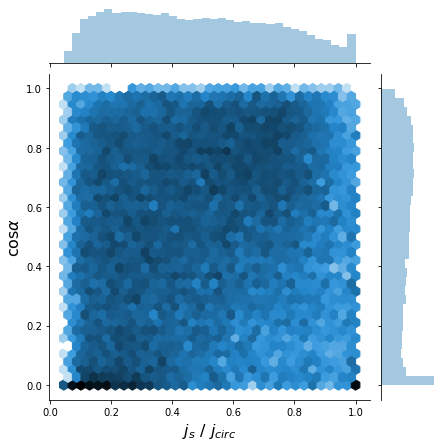

In [93]:
import seaborn as sns
print(param_beta)
print(param_gauss)
gauss_to_uniform = stats.norm(*param_gauss).cdf(disk_j)
beta_to_uniform = stats.beta(*param_beta).cdf((disk_cos))
h = sns.jointplot(gauss_to_uniform, beta_to_uniform, kind='hex', stat_func=None,norm=matplotlib.colors.LogNorm())
h.set_axis_labels(r'$j_{s}$ / $j_{circ}$', r'cos$\alpha$', fontsize=16);

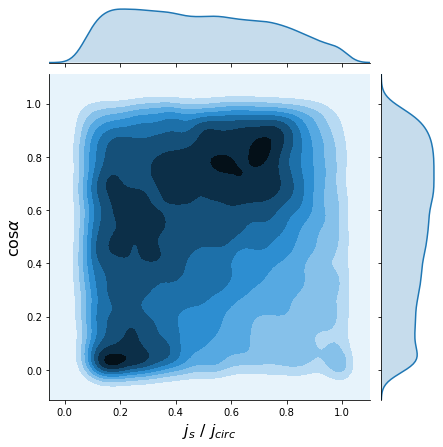

In [94]:
import seaborn as sns

gauss_to_uniform = stats.norm(*param_gauss).cdf(disk_j)
beta_to_uniform = stats.beta(*param_beta).cdf(abs(disk_cos))
h = sns.jointplot(gauss_to_uniform, beta_to_uniform, kind='kde', stat_func=None)
h.set_axis_labels(r'$j_{s}$ / $j_{circ}$', r'cos$\alpha$', fontsize=16);

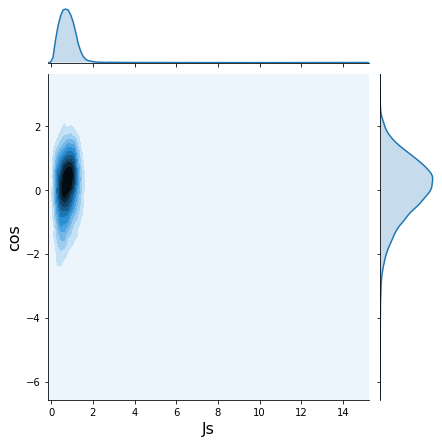

In [95]:
from pomegranate import *
beta_to_uniform_to_gauss = stats.norm( ).ppf((beta_to_uniform))
h = sns.jointplot(disk_j, beta_to_uniform_to_gauss, kind='kde', stat_func=None)
h.set_axis_labels('Js', 'cos', fontsize=16);





In [96]:
matr = np.vstack( (disk_j, beta_to_uniform_to_gauss) ).T
matr.shape

(30601, 2)

In [20]:
# mvn =  MultivariateGaussianDistribution.from_samples( matr )
# mvn.fit(matr)

# mvn.parameters
# mvn.parameters[0]
# mvn.parameters[1]

In [21]:
# a=mvn.parameters[0][0]
# b=mvn.parameters[0][1]
# c=mvn.parameters[1][0][0]
# d=mvn.parameters[1][0][1]
# e=mvn.parameters[1][1][0]
# f=mvn.parameters[1][1][1]
# mvnorm = stats.multivariate_normal(mean=[a, b], cov=[[c, d], 
#                                                      [e, f]])
# # Generate random samples from multivariate normal with correlation .5
# x_bi = mvnorm.rvs(10000)
# h = sns.jointplot(x_bi[:,0], x_bi[:,1], stat_func=None,kind='kde')
# h.set_axis_labels('X1', 'X2', fontsize=16);

[[0.21984006 0.0169661 ]
 [0.0169661  0.97739173]]
[0.79650219 0.0231475 ]
0.0169661016680858
0.07895989498485527


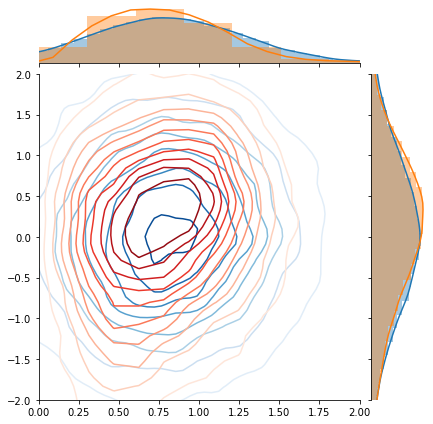

In [97]:
covar = np.cov(matr.T)
means = np.mean(matr, axis=0)
print(covar)
print(means)
print(covar[0][1])
print(covar[0][1]/(covar[0][0]*covar[1][1]))
mvnorm = stats.multivariate_normal(mean=means, cov=covar)
# Generate random samples from multivariate normal with correlation .5
x_bi = mvnorm.rvs(len(disk_j))
# h = sns.jointplot(x_bi[:,0], x_bi[:,1], stat_func=None,kind='kde')
# h.set_axis_labels('X1', 'X2', fontsize=16)
# k = sns.jointplot(disk_j, beta_to_uniform_to_gauss, stat_func=None,kind='kde')

g = sns.JointGrid(x_bi[:,0], x_bi[:,1])
kwargs = {'levels': np.arange(0, 1, 0.1)}
sns.distplot(x_bi[:,0], ax=g.ax_marg_x)
sns.distplot(x_bi[:,1], ax=g.ax_marg_y,vertical=True)
sns.distplot(disk_j, ax=g.ax_marg_x)
sns.distplot(beta_to_uniform_to_gauss, ax=g.ax_marg_y,vertical=True)
sns.kdeplot (x_bi[:,0], x_bi[:,1] , cmap="Blues",linewidths=1.5 ,ax=g.ax_joint )
sns.kdeplot (disk_j, beta_to_uniform_to_gauss , cmap="Reds" ,linewidths=1.5,ax=g.ax_joint )
plt.ylim(-2,2)
g.ax_marg_x.set_xlim(0,2)
h.set_axis_labels(r'$j_{s}$ / $j_{circ}$', r'cos$\alpha$', fontsize=16);

0.02314749665577012
0.024276180295041402


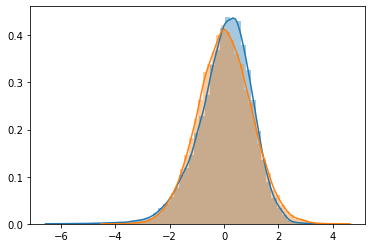

In [98]:
print(matr[:,1].mean())
print(x_bi[:,1].mean())

sns.distplot(beta_to_uniform_to_gauss)
sns.distplot(x_bi[:,1])
plt.show()

[[0.21984006 0.0169661 ]
 [0.0169661  0.97739173]]
[[0.21984006 0.13906217]
 [0.13906217 0.97739173]]
0.07895989498485527
0.6471925407850126


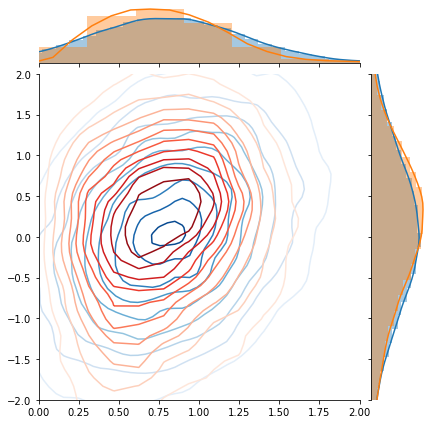

In [99]:

covar_03 = numpy.copy(covar)
covar_03[0][1] = 0.3*sqrt(covar[0][0])*sqrt(covar[1][1])
covar_03[1][0] = 0.3*sqrt(covar[0][0])*sqrt(covar[1][1])
means = np.mean(matr, axis=0)
print(covar )
print(covar_03 )
print(covar[0][1]/(covar[0][0]*covar[1][1]))
print(covar_03[0][1]/(covar_03[0][0]*covar_03[1][1]))
mvnorm_03 = stats.multivariate_normal(mean=means, cov=covar_03)
# Generate random samples from multivariate normal with correlation .5
x_bi_03 = mvnorm_03.rvs(len(disk_j))
g = sns.JointGrid(x_bi_03[:,0], x_bi_03[:,1])
kwargs = {'levels': np.arange(0, 1, 0.1)}
sns.distplot(x_bi_03[:,0], ax=g.ax_marg_x)
sns.distplot(x_bi_03[:,1], ax=g.ax_marg_y,vertical=True)
sns.distplot(disk_j, ax=g.ax_marg_x)
sns.distplot(beta_to_uniform_to_gauss, ax=g.ax_marg_y,vertical=True)
sns.kdeplot (x_bi_03[:,0], x_bi_03[:,1] , cmap="Blues",linewidths=1.5 ,ax=g.ax_joint )
sns.kdeplot (disk_j, beta_to_uniform_to_gauss , cmap="Reds" ,linewidths=1.5,ax=g.ax_joint )
plt.ylim(-2,2)
g.ax_marg_x.set_xlim(0,2)
h.set_axis_labels(r'$j_{s}$ / $j_{circ}$', r'cos$\alpha$', fontsize=16);

In [100]:

gauss_samples = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples= stats.beta(*param_beta).rvs(len(disk_j))

[inf]
[]
[inf inf inf inf]
[]


Text(0.5, 0, '$j_{s}$ / $j_{circ}$')

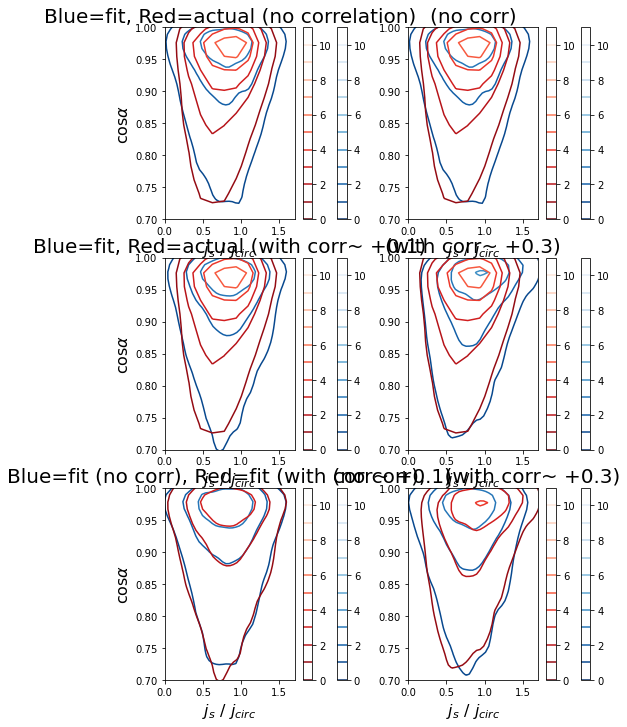

In [101]:
figure(figsize=(8,12))
tight_layout(pad=3.0)
subplot(3,2,1)
plt.ylim(0.7,1)
plt.xlim(0,1.7)
kwargs = {'levels': np.arange(0, 12, 1)}
sns.kdeplot (gauss_samples, beta_samples , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (disk_j, disk_cos , cmap="Reds_r" ,linewidths=1.5,cbar=True,**kwargs)
title('Blue=fit, Red=actual (no correlation)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
ylabel(r'cos$\alpha$', fontsize=16)

subplot(3,2,3)
mvn_norm_js = stats.norm(means[0],covar[0][0]).cdf(x_bi[:,0])
mvn_norm_cos = stats.norm(means[1],covar[1][1]).cdf(x_bi[:,1])
mvn_norm_js_gauss = stats.norm(*param_gauss).ppf(mvn_norm_js)
mvn_norm_cos_beta = stats.beta(*param_beta).ppf(mvn_norm_cos)
kwargs = {'levels': np.arange(0, 12, 1)}
print(mvn_norm_js_gauss[mvn_norm_js_gauss==np.inf])
print(mvn_norm_cos_beta[mvn_norm_cos_beta==np.inf])
plt.ylim(0.7,1)
plt.xlim(0,1.7)
sns.kdeplot (x_bi[:,0], mvn_norm_cos_beta , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (disk_j, disk_cos , cmap="Reds_r" ,linewidths=1.5,cbar=True,**kwargs)
title('Blue=fit, Red=actual (with corr~ +0.1)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
ylabel(r'cos$\alpha$', fontsize=16)


subplot(3,2,5)
gauss_samples1 = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples1= stats.beta(*param_beta).rvs(len(disk_j))
gauss_samples2 = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples2= stats.beta(*param_beta).rvs(len(disk_j))
plt.ylim(0.7,1)
plt.xlim(0,1.7)
kwargs = {'levels': np.arange(0, 12, 1)}
sns.kdeplot (gauss_samples1, beta_samples1 , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (x_bi[:,0], mvn_norm_cos_beta , cmap="Reds_r",linewidths=1.5 ,cbar=True,**kwargs)
title('Blue=fit (no corr), Red=fit (with corr~ +0.1)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
ylabel(r'cos$\alpha$', fontsize=16)

subplot(3,2,2)
plt.ylim(0.7,1)
plt.xlim(0,1.7)
kwargs = {'levels': np.arange(0, 12, 1)}
sns.kdeplot (gauss_samples, beta_samples , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (disk_j, disk_cos , cmap="Reds_r" ,linewidths=1.5,cbar=True,**kwargs)
title('(no corr)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
 

subplot(3,2,4)
mvn_norm_js = stats.norm(means[0],covar[0][0]).cdf(x_bi_03[:,0])
mvn_norm_cos = stats.norm(means[1],covar[1][1]).cdf(x_bi_03[:,1])
mvn_norm_js_gauss = stats.norm(*param_gauss).ppf(mvn_norm_js)
mvn_norm_cos_beta = stats.beta(*param_beta).ppf(mvn_norm_cos)
kwargs = {'levels': np.arange(0, 12, 1)}
print(mvn_norm_js_gauss[mvn_norm_js_gauss==np.inf])
print(mvn_norm_cos_beta[mvn_norm_cos_beta==np.inf])
plt.ylim(0.7,1)
plt.xlim(0,1.7)
sns.kdeplot (x_bi_03[:,0], mvn_norm_cos_beta , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (disk_j, disk_cos , cmap="Reds_r" ,linewidths=1.5,cbar=True,**kwargs)
title('(with corr~ +0.3)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
 


subplot(3,2,6)
gauss_samples1 = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples1= stats.beta(*param_beta).rvs(len(disk_j))
gauss_samples2 = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples2= stats.beta(*param_beta).rvs(len(disk_j))
plt.ylim(0.7,1)
plt.xlim(0,1.7)
kwargs = {'levels': np.arange(0, 12, 1)}
sns.kdeplot (gauss_samples1, beta_samples1 , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (x_bi_03[:,0], mvn_norm_cos_beta , cmap="Reds_r",linewidths=1.5 ,cbar=True,**kwargs)
title(' (no corr),   (with corr~ +0.3)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)




[inf]
[]


Text(0, 0.5, 'cos$\\alpha$')

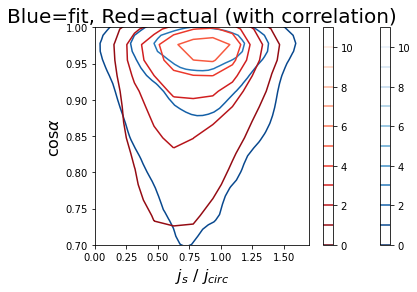

In [102]:
mvn_norm_js = stats.norm(means[0],covar[0][0]).cdf(x_bi[:,0])
mvn_norm_cos = stats.norm(means[1],covar[1][1]).cdf(x_bi[:,1])
mvn_norm_js_gauss = stats.norm(*param_gauss).ppf(mvn_norm_js)
mvn_norm_cos_beta = stats.beta(*param_beta).ppf(mvn_norm_cos)
kwargs = {'levels': np.arange(0, 12, 1)}
print(mvn_norm_js_gauss[mvn_norm_js_gauss==np.inf])
print(mvn_norm_cos_beta[mvn_norm_cos_beta==np.inf])
plt.ylim(0.7,1)
plt.xlim(0,1.7)
sns.kdeplot (x_bi[:,0], mvn_norm_cos_beta , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (disk_j, disk_cos , cmap="Reds_r" ,linewidths=1.5,cbar=True,**kwargs)
title('Blue=fit, Red=actual (with correlation)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
ylabel(r'cos$\alpha$', fontsize=16)

Text(0, 0.5, 'cos$\\alpha$')

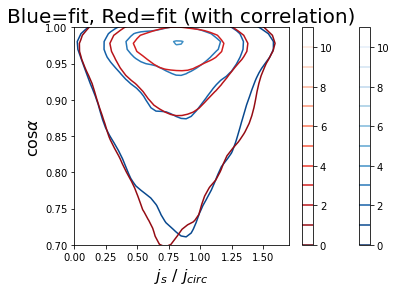

In [103]:
gauss_samples1 = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples1= stats.beta(*param_beta).rvs(len(disk_j))
gauss_samples2 = stats.norm(*param_gauss).rvs(len(disk_j))
beta_samples2= stats.beta(*param_beta).rvs(len(disk_j))
plt.ylim(0.7,1)
plt.xlim(0,1.7)
kwargs = {'levels': np.arange(0, 12, 1)}
sns.kdeplot (gauss_samples1, beta_samples1 , cmap="Blues_r",linewidths=1.5 ,cbar=True,**kwargs)
sns.kdeplot (x_bi[:,0], mvn_norm_cos_beta , cmap="Reds_r",linewidths=1.5 ,cbar=True,**kwargs)
title('Blue=fit, Red=fit (with correlation)',fontsize = 20)
xlabel(r'$j_{s}$ / $j_{circ}$', fontsize=16)
ylabel(r'cos$\alpha$', fontsize=16)

In [ ]:
1. empirical disk model from monte carlo
2. if my model is little wrong , tweak my disk model so it doesn match data. how much output quants modified, but how wrong. 
fake bulge data fake disk data. Models not perfect, how much does it matter for the quantitites we measure.
data from tng, analytic model for bulge, or/and disk model. 

In [ ]:
sample from massive galaxies. how does the time scale
